In [1]:
import os
import re
import string

import numpy as np
from tqdm import tqdm
import jiwer

import _pickle as pickle

import sys
sys.path.insert(0, '..')

from enums.language import Language

In [2]:
def get_folder_paths():
    newseye_path = os.path.join('..', 'data', 'newseye')

    icdar_2017_path = os.path.join(newseye_path, '2017', 'full')
    icdar_2019_path = os.path.join(newseye_path, '2019', 'full')

    result = {
        Language.English: [
            os.path.join(icdar_2017_path, 'eng_monograph'),
            os.path.join(icdar_2017_path, 'eng_periodical'),
            os.path.join(icdar_2019_path, 'EN')
        ],
        Language.Dutch: [
            os.path.join(icdar_2019_path, 'NL', 'NL1')
        ],
        Language.French: [
            os.path.join(icdar_2017_path, 'fr_monograph'),
            os.path.join(icdar_2017_path, 'fr_periodical'),
            os.path.join(icdar_2019_path, 'FR', 'FR1'),
            os.path.join(icdar_2019_path, 'FR', 'FR2'),
            os.path.join(icdar_2019_path, 'FR', 'FR3'),
        ],
        Language.German: [
            os.path.join(icdar_2019_path, 'DE', 'DE1'),
            os.path.join(icdar_2019_path, 'DE', 'DE2'),
            os.path.join(icdar_2019_path, 'DE', 'DE3'),
            os.path.join(icdar_2019_path, 'DE', 'DE4'),
            os.path.join(icdar_2019_path, 'DE', 'DE5'),
            os.path.join(icdar_2019_path, 'DE', 'DE6'),
            os.path.join(icdar_2019_path, 'DE', 'DE7'),
        ]
    }

    return result

In [3]:
def simple_cer(text1, text2):

    total = len(text1)
    matches = 0
    for char1, char2 in zip(text1, text2):
        if char1 == char2:
            matches += 1

    result = (total - matches) / float(total)
    return result

In [4]:
def save_cache(cache_filepath, cache_obj):
    with open(cache_filepath, 'wb') as cache_file:
        pickle.dump(cache_obj, cache_file)

def calculate_error_rates(specific_language: Language = None):
    result = {}

    paths_by_language = get_folder_paths()

    for language, folder_paths in paths_by_language.items():
        if specific_language is not None and language != specific_language: continue

        tot = 0
        paths = []
        for folder_path in folder_paths:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                paths.append(file_path)

        # result[language] = {
        #     'wer': np.zeros(len(paths)),
        #     'cer': np.zeros(len(paths))
        # }
        result[language] = {
            'wer': [],
            'cer': []
        }

        # result[language]['wer'].fill(-1)
        # result[language]['cer'].fill(-1)

        cache_filepath = os.path.join('results', f'errors_cache_{language.value}.pickle')
        if os.path.exists(cache_filepath):
            with open(cache_filepath, 'rb') as cache_file:
                cache = pickle.load(cache_file)
        else:
            cache = result[language]

        for i, file_path in enumerate(tqdm(paths, desc=f'Computing \'{language.value}\'', total=len(paths))):
            with open(file_path, 'r', encoding='utf-8') as text_file:

                file_lines = text_file.readlines()
                gt_line = file_lines[2][14:].rstrip()
                ocr_line = file_lines[1][14:].rstrip()

                if len(cache['wer']) > i + 1:
                    result[language]['wer'].append(cache['wer'][i])
                    result[language]['cer'].append(cache['cer'][i])
                    continue

                cer_func = simple_cer
                if len(gt_line) != len(ocr_line):
                    tot += 1
                    # cer_func = cer
                    continue

                n = 50000
                if len(gt_line) > n:
                    gt_chunks = [gt_line[i:i+n] for i in range(0, len(gt_line), n)]
                    ocr_chunks = [ocr_line[i:i+n] for i in range(0, len(ocr_line), n)]

                    temp_wer = []
                    temp_cer = []
                    for gt_chunk, ocr_chunk in zip(gt_chunks, ocr_chunks):
                        wer_value = jiwer.wer(gt_chunk, ocr_chunk)
                        if wer_value > 1:
                            wer_value = 1

                        temp_wer.append(wer_value)

                        if wer_value > 100:
                            print(f'{gt_chunk}\n--------------\n{ocr_chunk}\n-----------\nERR:{wer_value}')
                            raise Exception('test')

                        temp_cer.append(cer_func(gt_chunk, ocr_chunk))

                    result[language]['wer'].append(np.mean(temp_wer))
                    result[language]['cer'].append(np.mean(temp_cer))
                else:
                    wer_value = jiwer.wer(gt_line, ocr_line)
                    if wer_value > 1:
                        wer_value = 1

                    result[language]['wer'].append(wer_value)
                    result[language]['cer'].append(cer_func(gt_line, ocr_line))

                if i % 10 == 0:
                    save_cache(cache_filepath, cache)

        print(language, tot)

    return result

In [5]:
# ground_truth = """32 7dk VERGADERING. - 23 NOVEMBER 1814. Berekeningen betreffende de Staatsbegrooting voor 1815. ZESDE POST. Departement van Bultenlandsche Zaken. Art. 1. De Secretaris van Staat en deszelfs bureaux: a. Tractement en tafelgelden van den Secretaris van Staat f 22,000.0.0 b. Tractementen van de secretarissen, commissaris, geëmployeerden en suppoosten. . . . 23,500.0.0 c. Schrijfloonen 3,000.0.0 d. Schoonhouden der bureaux, aankoop en onderhoud van meubelen en verdere behoeften . 2,000.0.0 f 50,500.0.0 Art. 2. Missiën en consulaten: a. Tractementen van de gezanten buiteu ’slands f 426,900.0.0 b. Tractementen van de consuls buiten ’slands 36,700.0.0 463,600.0.0 Art. 3. Commerciële onkosten : Gewone en buitengewone geschenken aan de Barbarijsche en Moorsche mogendheden 100,000.0.0 Art. 4. Onkosten van verschillenden aard: a. Equipement-gelden en reiskosten f b. Buitengewone bezendingen of commissiën buiten ’slands c. Presenten, welke ter gelegenheid van het sluiten van tractaten, conventiën enz. gegeven worden d. Presenten aan vreemde ministers, die gerappelleerd worden, mitsgaders dedommagement ter zake van de impositiën, aan de vreemde gezanten (die zulks verkiezen) bij hun arrivement te geven e. Secrete diensten f. Onvoorziene uitgaven 175,000.0.0 30,000.0.0 30,000.0.0 30.000. 0.0 20.000. 0.0 25.000. 0.0 40.000. 0.0 Totaal . . f 789,100.0.0 ZEVENDE POST. Departement van Marine. Art. 1. De Secretaris van Staat en deszelfs bureaux: a. De Secretaris van Staat f 10,000. 0.0 b. De bureaux 53,400. 0.0 c. Generale ambtenaren en verdere kosten . 152,865.15.0 f 216,265.15.0 Art. 2. Tractementen , soldijen , hospitalen en loodswezen: a. Tractementen der officieren f 398,950.0.0 b. Soldijen van het scheepsvolk en kleeding der jachtvolkeren 829,941.0.0 c. Verzorging der hospitalen 120,000.0.0 d. Kosten van het loodswezen , seinposten , tonnen en baken 85,000.0.0 e. Maritime etablissementen 27,000.0.0 1,460,891. 0.0"""
# hypothesis = "@@@@@@@@@@@@@@@@@@@@@ @3@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@2 ZESDE POST. Departement van Buitenlandsche Zaken. Art. 1. De Secretaris van Staat en deszelfs bureaux:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Art. 2. Missiën en consulaten:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Art. 3. Commerciële onkosten@:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Art. 4. Onkosten van verschillenden aard:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ZEVENDE POST. Departement van Marine. Art. 1. De Secretaris van Staat en deszelfs bureaux:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Art. 2. Tractementen@, soldijen@, hospitalen en loodswezen:@@@ @@@@@@@@@7DE @@VERGADERING. @ @@@@@@@@@@@ 23 NOVEMBER @@1814. @@@Be@@@@@@re@@k@@ening@@@@@@@@@@@@@@@@en@@@@@@@@@@@@@@@ be@@tr@@@@@@e@@@@@@@@@ﬀen@@@@@@@@@@@@@d@@@@@@@@@@@@@@e@ @@@d@@@@e@@@ @@@@@@St@@@aat@@@@@@@@sb@@@@@@@@@@@@@@@@e@@@gr@@@@@oot@@@i@@@@@n@@g @@@@@@voor 1@@@@@8@1@@5.@"

# jiwer.wer(ground_truth, hypothesis)

In [6]:
error_rates_per_language = calculate_error_rates()

Computing 'dutch':   4%|▍         | 6/150 [00:00<00:02, 54.76it/s]

english 12


Computing 'french':   0%|          | 0/3993 [00:00<?, ?it/s]

dutch 1


Computing 'german':   0%|          | 0/10032 [00:00<?, ?it/s]

french 377


Computing 'german': 100%|██████████| 10032/10032 [01:14<00:00, 134.56it/s]

german 8294


In [7]:
print([(lang, len(x['wer'])) for lang, x in error_rates_per_language.items()])

[(<Language.English: 'english'>, 951), (<Language.Dutch: 'dutch'>, 149), (<Language.French: 'french'>, 3616), (<Language.German: 'german'>, 1738)]


In [8]:
for language, error_rates in error_rates_per_language.items():
    print(f'{language.value.capitalize()} & {round(np.mean(error_rates["cer"]), 3)} & {round(np.mean(error_rates["wer"]), 3)} \\\\')
    # print(f'\\item {language.value.capitalize()} CER: {round(np.mean(error_rates["cer"]), 3)}')

English & 0.075 & 0.146 \\
Dutch & 0.286 & 0.536 \\
French & 0.064 & 0.193 \\
German & 0.24 & 0.813 \\


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'cm'

sns.set()
sns.set(font_scale=2)  # crazy big
sns.set_style('ticks')

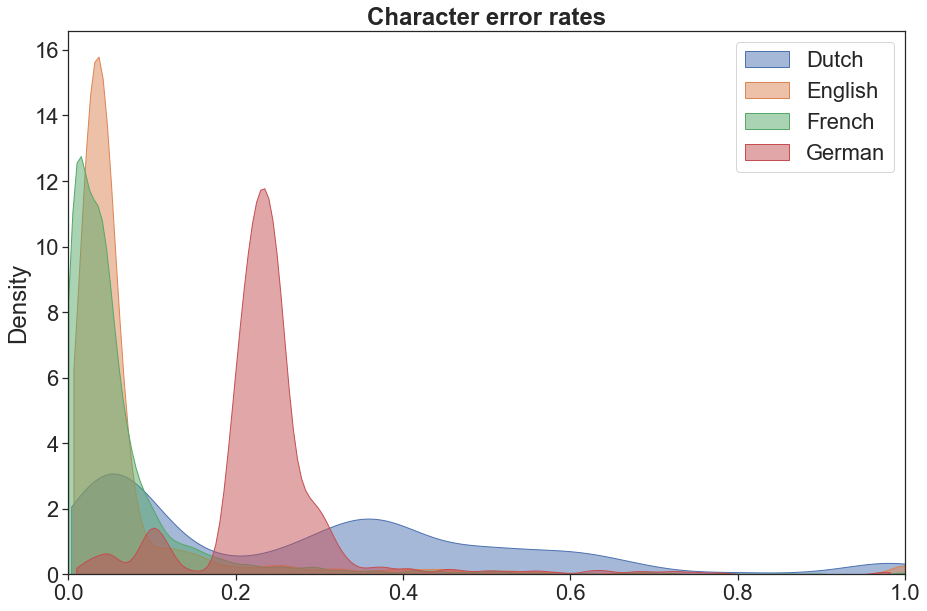

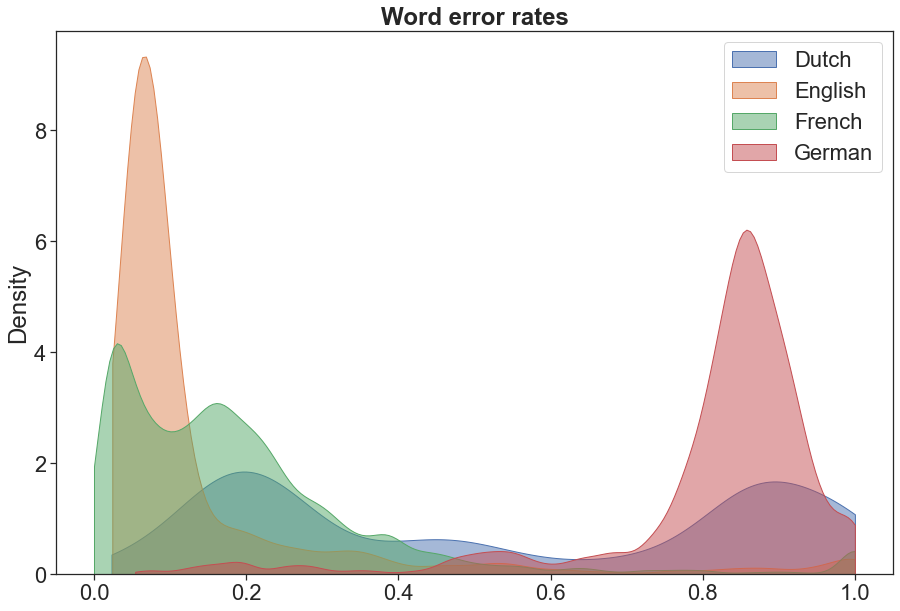

In [10]:
def plot_errors_dist(errors, labels, title, use_lim=False):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for error_values, label in zip(errors, labels):
        ax = sns.kdeplot(
            data=error_values,
            fill=True,
            bw_adjust=.5,
            cut=0,
            clip=(0,1) if use_lim else None,
            label=label,
            legend=True,
            # linewidth=0,
            alpha=.5,
            ax=ax
        )

    if use_lim:
        ax.set_xlim(0, 1)

    ax.set_title(title, fontdict={'fontweight': 'bold'}, pad=None)
    ax.legend()
    plt.savefig(os.path.join('results', title.lower().replace(' ', '_')), bbox_inches='tight')

plot_errors_dist([
    error_rates_per_language[Language.Dutch]['cer'],
    error_rates_per_language[Language.English]['cer'],
    error_rates_per_language[Language.French]['cer'],
    error_rates_per_language[Language.German]['cer']
    ],
    labels=['Dutch', 'English', 'French', 'German'],
    title='Character error rates',
    use_lim=True)

plot_errors_dist([
    error_rates_per_language[Language.Dutch]['wer'],
    error_rates_per_language[Language.English]['wer'],
    error_rates_per_language[Language.French]['wer'],
    error_rates_per_language[Language.German]['wer']
    ],
    labels=['Dutch', 'English', 'French', 'German'],
    title='Word error rates')

In [11]:
def calculate_language_data_size():
    paths_by_language = get_folder_paths()
    result = {}

    for language, folder_paths in paths_by_language.items():

        paths = []
        for folder_path in folder_paths:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                paths.append(file_path)

        result[language] = {
            'chars': [],
            'words': []
        }

        for file_path in tqdm(paths, desc=f'Computing \'{language.value}\'', total=len(paths)):
            with open(file_path, 'r', encoding='utf-8') as text_file:

                file_lines = text_file.readlines()
                gt_line = file_lines[2][14:]

                chars = len(gt_line)
                words = len(gt_line.split())
                result[language]['chars'].append(chars)
                result[language]['words'].append(words)

    return result

data_stats = calculate_language_data_size()

Computing 'german': 100%|██████████| 10032/10032 [00:02<00:00, 4401.04it/s]


In [12]:
error_rates_per_language[Language.Dutch]['cer'][2]

0.5181256629437824

In [22]:
split_documents_lengths = {}
for language in [Language.Dutch, Language.English, Language.French, Language.German]:
    split_path = os.path.join('..', '.cache', 'ocr-evaluation', language.value, 'ocr-gs-file-data-icdar-2017-icdar-2019-128.pickle')
    if not os.path.exists(split_path):
        continue

    with (open(split_path, "rb")) as openfile:
        obj = pickle.load(openfile)

    print(language)
    print(len(obj[1]))
    print(len(obj[0]))

    # break

dutch
5346
5346
english
51689
51689
french
84676
84676
german
128662
128662


In [14]:
for language in [Language.Dutch, Language.English, Language.French, Language.German]:
    print(f'\\item {language.value.capitalize()}: \\\\')
    print(f' - total documents: {len(data_stats[language]["chars"])} \\\\')
    print(f' - valid (equal length) documents: {len(error_rates_per_language[language]["wer"])} \\\\')
    print(f' - amount of characters [avg: {int(round(np.mean(data_stats[language]["chars"]), 0))}, min: {min(data_stats[language]["chars"])}, max: {max(data_stats[language]["chars"]):,}] \\\\')
    print(f' - amount of words [avg: {int(round(np.mean(data_stats[language]["words"]),0))}, min: {min(data_stats[language]["words"])}, max: {max(data_stats[language]["words"]):,}] \\\\')
    print(f' - total characters: {sum(data_stats[language]["chars"])}')

\item Dutch: \\
 - total documents: 150 \\
 - valid (equal length) documents: 149 \\
 - amount of characters [avg: 4593, min: 42, max: 16,028] \\
 - amount of words [avg: 689, min: 1, max: 2,493] \\
 - total characters: 688934
\item English: \\
 - total documents: 963 \\
 - valid (equal length) documents: 951 \\
 - amount of characters [avg: 6866, min: 2, max: 869,953] \\
 - amount of words [avg: 1153, min: 1, max: 147,046] \\
 - total characters: 6612108
\item French: \\
 - total documents: 3993 \\
 - valid (equal length) documents: 3616 \\
 - amount of characters [avg: 2660, min: 2, max: 195,177] \\
 - amount of words [avg: 433, min: 1, max: 32,513] \\
 - total characters: 10620966
\item German: \\
 - total documents: 10032 \\
 - valid (equal length) documents: 1738 \\
 - amount of characters [avg: 1581, min: 126, max: 16,187] \\
 - amount of words [avg: 218, min: 4, max: 1,969] \\
 - total characters: 15856445
